1. Объясните, почему коэффициенты всех построенных моделей сильно отличаются между собой.


2. Сравните скорость и качество обучения моделей регрессии с помощью обычного и стохастического градиентного спуска на наборе данных housing.csv.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split


df = pd.read_csv('housing.csv')

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Columns: 104 entries, Column1 to Column104
dtypes: float64(104)
memory usage: 411.3 KB


In [38]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr 
        # максимальное число итераций
        self.max_iteration = max_iter 
        # критерий сходимости  
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta = None
        self.n = None
        self.d = None
         
    def fit(self, X, y):
        self.X = X.to_numpy().copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))   
        # размерность вектора X 
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors = [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.theta -= self.learning_rate * grad
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            step += 1
            steps.append(step)
            errors.append(new_error)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors
    
    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)
             
    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta
    
    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
    
    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()
    
    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

In [39]:
class LinearRegressionSGD:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, intercept=True, regularization=None, alpha=0.01):
        self.learning_rate = lr 
        self.max_iteration = max_iter 
        self.tolerance_convergence = tol
        self.intercept = intercept
        self.theta = None
        self.regularization = regularization
        self.alpha = alpha
        
    def fit(self, X, y):
        self.X = X.copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        
        self.n, self.d = self.X.shape
        self.theta = np.random.randn(self.d)
        
        steps, errors = [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            if self.regularization == 'l1':
                self.theta -= self.alpha * np.sign(self.theta)
                grad += self.alpha * np.sign(self.theta)
            elif self.regularization == 'l2':
                self.theta -= 2 * self.alpha * self.theta
                grad += 2 * self.alpha * self.theta
            elif self.regularization == 'elasticnet':
                self.theta -= self.alpha * self.theta + (1 - self.alpha) * np.sign(self.theta)
                grad += self.alpha * self.theta + (1 - self.alpha) * np.sign(self.theta)
            
            self.theta -= self.learning_rate * grad
            
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            step += 1
            steps.append(step)
            errors.append(new_error)
            
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        
        return steps, errors
    
    def gradient(self, X, y):
        grad = X.T @ (X @ self.theta - y) / len(y)
        if self.regularization == 'l1':
            grad += self.alpha * np.sign(self.theta)
        elif self.regularization == 'l2':
            grad += 2 * self.alpha * self.theta
        elif self.regularization == 'elasticnet':
            grad += self.alpha * self.theta + (1 - self.alpha) * np.sign(self.theta)
        
        return grad
    
    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        else:
            X_ = X
        return X_ @ self.theta
    
    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
    
    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()
    
    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

    def MSE_with_regularization(self, X, y):
        regularization_term = 0

        if self.regularization == 'l1':
            regularization_term = self.alpha * np.sum(np.abs(self.theta[1:]))  # Исключаем intercept
        elif self.regularization == 'l2':
            regularization_term = self.alpha * np.sum(self.theta[1:]**2)  # Исключаем intercept
        elif self.regularization == 'elasticnet':
            l1_term = self.alpha * np.sum(np.abs(self.theta[1:]))  # Исключаем intercept
            l2_term = (1 - self.alpha) * np.sum(self.theta[1:]**2)  # Исключаем intercept
            regularization_term = l1_term + l2_term

        error = ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
        mse_with_reg = error + regularization_term / len(y)
        return mse_with_reg


Сравнение скорости и качества обучения:
Время обучения (GD): 0.23999929428100586 сек.
Время обучения (SGD): 0.023000478744506836 сек.
MSE (GD)test: 41.081306723650876, MSE (GD)train : 39.646254118452845 
MSE (SGD)test: 25.302850554496253, MSE (SGD)train: 22.605822916288115 


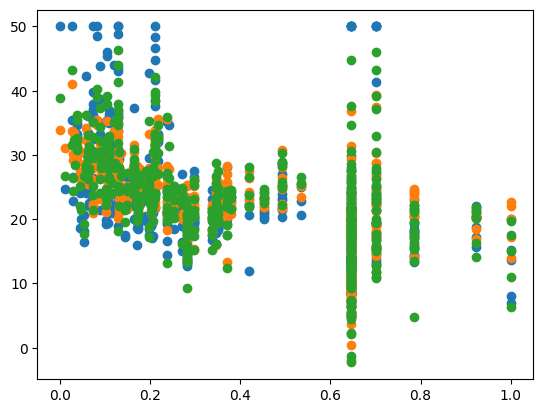

In [40]:
# Создание модели с обычным градиентным спуском
modelGD = LinearRegressionGD(lr=0.01, max_iter=400, tol=1e-3, intercept=True)

# Измерение времени обучения для обычного градиентного спуска
start_time = time.time()
stepsGD, errorsGD = modelGD.fit(X_train, y_train)
training_time_GD = time.time() - start_time

# Создание модели со стохастическим градиентным спуском
modelSGD = LinearRegressionSGD(lr=0.01, max_iter=50, batch_size=8, tol=1e-3, intercept=True)

# Измерение времени обучения для стохастического градиентного спуска
start_time = time.time()
stepsSGD, errorsSGD = modelSGD.fit(X_train, y_train)
training_time_SGD = time.time() - start_time

MSE_GD_train = modelGD.MSE(X_train, y_train)
MSE_SGD_train = modelSGD.MSE(X_train, y_train)

# Оценка качества моделей на тестовом наборе данных
MSE_GD = modelGD.MSE(X_test, y_test)
MSE_SGD = modelSGD.MSE(X_test, y_test)

# Вывод результатов
print("Сравнение скорости и качества обучения:")
print(f"Время обучения (GD): {training_time_GD} сек.")
print(f"Время обучения (SGD): {training_time_SGD} сек.")
print(f"MSE (GD)test: {MSE_GD}, MSE (GD)train : {MSE_GD_train} ")
print(f"MSE (SGD)test: {MSE_SGD}, MSE (SGD)train: {MSE_SGD_train} ")
# print("Коэффициенты (GD): ", modelGD.theta)
# print("Коэффициенты (SDG): ", modelSGD.theta)

y_pred_GD = modelGD.predict(X)
y_pred_SGD = modelSGD.predict(X)
X_numpy = X.to_numpy()  # Преобразовать DataFrame в NumPy массив
plt.scatter(X_numpy[:, 2], y)
plt.scatter(X_numpy[:, 2], y_pred_GD)
plt.scatter(X_numpy[:, 2], y_pred_SGD)

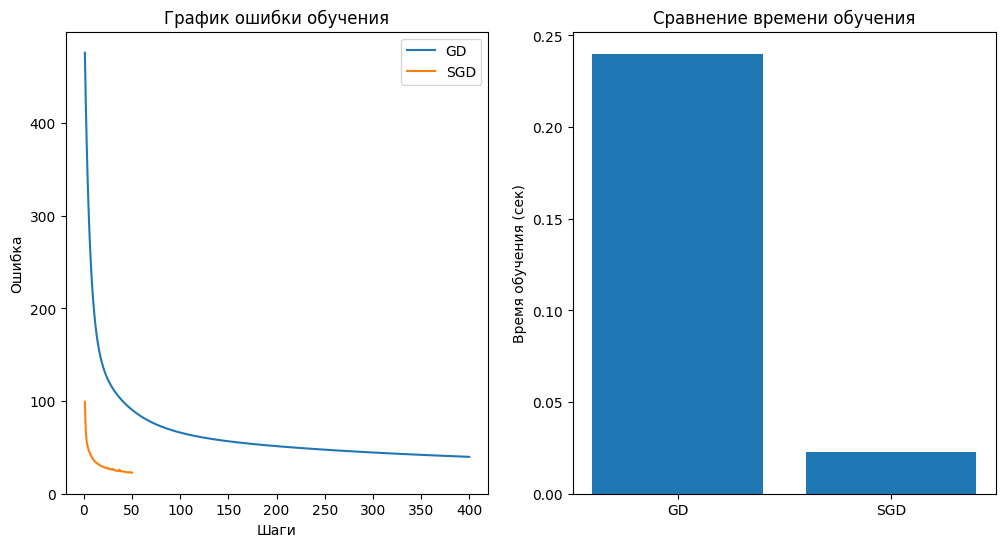

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(stepsGD, errorsGD, label='GD')
plt.plot(stepsSGD, errorsSGD, label='SGD')
plt.xlabel("Шаги")
plt.ylabel("Ошибка")
plt.legend()
plt.title("График ошибки обучения")

plt.subplot(1, 2, 2)
plt.bar(['GD', 'SGD'], [training_time_GD, training_time_SGD])
plt.ylabel("Время обучения (сек)")
plt.title("Сравнение времени обучения")
plt.show()

Batch Size: 1, Training Time: 0.812997579574585 s, MSE: 11.038868682451955
Batch Size: 2, Training Time: 0.45351147651672363 s, MSE: 11.11321263518687
Batch Size: 4, Training Time: 0.23999953269958496 s, MSE: 11.924533780147536
Batch Size: 8, Training Time: 0.15199971199035645 s, MSE: 13.096306974424886
Batch Size: 16, Training Time: 0.11299991607666016 s, MSE: 16.21117248001603
Batch Size: 32, Training Time: 0.09099960327148438 s, MSE: 19.94175846474374


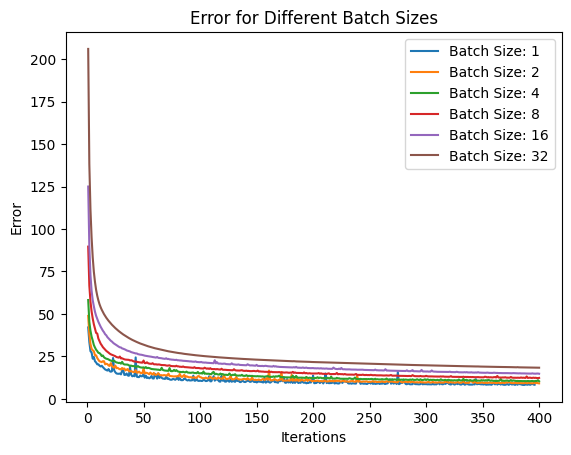

In [69]:
import matplotlib.pyplot as plt

batch_sizes = [1, 2, 4, 8, 16, 32]
results = []

for batch_size in batch_sizes:
    model_sgd = LinearRegressionSGD(lr=0.01, max_iter=400, batch_size=batch_size, tol=1e-3, intercept=True)
    start_time = time.time()
    steps, errors = model_sgd.fit(X_train, y_train)
    plt.plot(steps, errors, label=f'Batch Size: {batch_size}')
    training_time = time.time() - start_time
    mse = model_sgd.MSE(X_test, y_test)
    results.append((batch_size, training_time, mse))

for batch_size, training_time, mse in results:
    print(f"Batch Size: {batch_size}, Training Time: {training_time} s, MSE: {mse}")
    

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.title('Error for Different Batch Sizes')
plt.show()


In [70]:
model = LinearRegressionSGD(lr=0.01, max_iter=1000, batch_size=32, tol=1e-3, intercept=True)
reg_types = ["l1", "l2", "elasticnet"]
reg_params = [0.1, 0.01, 0.001]  # Пример значений для регуляризации

results = {}

for reg_type in reg_types:
    for reg_param in reg_params:
        model.regularization = reg_type
        model.alpha = reg_param
        steps, errors = model.fit(X_train, y_train)
        mse_train = model.MSE_with_regularization(X_train, y_train)
        mse_test = model.MSE_with_regularization(X_test, y_test)
        key = f"{reg_type}_{reg_param}"
        results[f'mse_train_{key}'] = mse_train
        results[f'mse_test_{key}'] = mse_test

AttributeError: 'LinearRegressionSGD' object has no attribute 'MSE_with_regularization'